In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt

In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [0]:
dataset = MNIST(root='data/', train=True, transform = transforms.ToTensor(), download=True)
test_data = MNIST(root='data/' , train=False , transform= transforms.ToTensor())

Label: 5


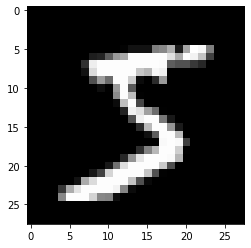

In [9]:
image, label = dataset[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [10]:
image.shape

torch.Size([1, 28, 28])

In [11]:
len(dataset)

60000

## Dataset and Dataloader

In [0]:
val_percent=0.1
num_rows = len(dataset)
val_size = int(num_rows * val_percent)
train_size = num_rows- val_size
train_ds,val_ds = random_split(dataset, [train_size,val_size])

In [0]:
batchSize = 32

In [0]:
train_loader = DataLoader(train_ds,batch_size=batchSize,shuffle=True)
val_loader = DataLoader(val_ds,batch_size=batchSize,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batchSize)

In [0]:
input_shape = 28*28
num_classes = 10

## Building A model

In [0]:
class Mnist_Model(nn.Module):

  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_shape,num_classes)
  
  def forward(self,xb):
    xb = xb.reshape(-1, 784)
    out =self.linear(xb)
    return out

  def training_step(self,batch):
    images,label = batch
    out = self(images)
    loss = F.cross_entropy(out,label)
    return loss

  def validation_step(self,batch):
    images,label = batch
    out = self(images)
    loss = F.cross_entropy(out,label)
    acc = accuracy(out,label)
    return {'val_loss' : loss.detach() , 'val_acc': acc.detach()}

  def validation_epoch_end(self,outputs):
    batch_losses =  [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() 
    batch_accuracy = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accuracy).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [0]:
model = Mnist_Model()

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Training a Model

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [0]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [34]:
history = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.2823, val_acc: 0.7949
Epoch [1], val_loss: 0.9481, val_acc: 0.8243
Epoch [2], val_loss: 0.7940, val_acc: 0.8436
Epoch [3], val_loss: 0.7061, val_acc: 0.8522
Epoch [4], val_loss: 0.6490, val_acc: 0.8582
Epoch [5], val_loss: 0.6068, val_acc: 0.8634
Epoch [6], val_loss: 0.5763, val_acc: 0.8664
Epoch [7], val_loss: 0.5512, val_acc: 0.8710
Epoch [8], val_loss: 0.5315, val_acc: 0.8715
Epoch [9], val_loss: 0.5150, val_acc: 0.8748


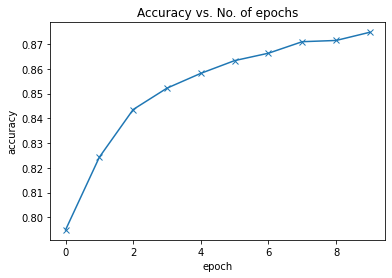

In [35]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

##  Evaluating on test data

In [36]:
evaluate(model, test_loader)

{'val_acc': 0.879792332649231, 'val_loss': 0.4920565187931061}

## Predicting on new image

In [0]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 9 , Predicted: 9


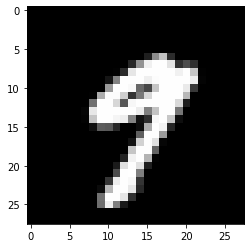

In [39]:
img, label = test_data[20]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))